In [1]:
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
import time
from PIL import Image
import datetime
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras.models import Sequential, Model, load_model, model_from_json
from tensorflow.keras.layers import Dense, Conv2D, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dropout, Activation
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import vgg16
from tensorflow.keras.utils import to_categorical  
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import SGD, Adam
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, classification_report, multilabel_confusion_matrix

In [2]:
#/global/scratch/users/cpezov/AAPBO/images/BenchmarkX/file_name.png
#/global/scratch/users/cpezov/AAPBO/labels.txt

x_train_all = []
y_train_all = []
x_test = []
y_test = []

main_path="/global/scratch/users/cpezov/AAPBO/"
d_path = main_path + "datasets-v4/"
i_path = main_path + "images/"

num_class=8 #7 solvers and "No solution"   #v4

#Get each one of the images, in order
#Randomly assign to test/train set, per family
random.seed(9)
with open(d_path+"txt_files/data_ordered.txt") as f:
    lines = f.readlines()
    for l in lines:
        r = random.randint(0,2)
        end = l.rfind(".")
        img_name = i_path + l[2:end] + ".png"
        #print(img_name)
        file_name = d_path + l[2:]
        #print(file_name)
        if(r==2):
            x_test.append(img_to_array(load_img(img_name,color_mode="grayscale")))
        else:
            x_train_all.append(img_to_array(load_img(img_name,color_mode="grayscale")))
        
print("X Train: "+str(len(x_train_all)))
print("X Test: "+str(len(x_test)))

#read labels and transform to one-hot
random.seed(9) #same seed to generate same random numbers as before 
with open(main_path+"labels-v4.txt") as f: #v4
    lines = f.readlines()
    for l in lines:
        r = random.randint(0,2)
        lbls = [int(x) for x in l.split()]
        one_hot = to_categorical(lbls, num_classes=num_class)
        if(r==2):
            y_test.append(one_hot)
        else:
            y_train_all.append(one_hot)
            
print("Y Train: "+str(len(y_train_all)))
print("Y Test: "+str(len(y_test)))
            
#x_train, x_test, y_train, y_test = model_selection.train_test_split (x, y, test_size=1./3.)

x_test = np.array(x_test)
y_test = np.array(y_test)

X Train: 2054
X Test: 1074
Y Train: 2054
Y Test: 1074


In [3]:
#Once separated train/test, the train set must be separated train/validation in 80:20 (4:1) ratio

x_train = []
y_train = []
x_val = []
y_val = []

random.seed(3)
for i in range(len(y_train_all)):
    r = random.randint(0,4)
    if(r==4):
        x_val.append(x_train_all[i])
        y_val.append(y_train_all[i])
    else:
        x_train.append(x_train_all[i])
        y_train.append(y_train_all[i])

x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(1645, 256, 256, 1)
(1645, 500, 8)
(409, 256, 256, 1)
(409, 500, 8)


In [4]:
img_size=256
input_shape = (img_size,img_size,1) #resolucion imagen original
loss="categorical_crossentropy"
opt = Adam(lr = 0.0001,epsilon=1e-08) 

#Modelo
vgg16_model = vgg16.VGG16(include_top=False, weights=None, input_tensor=None, input_shape=input_shape, pooling=max, classes=num_class) #primera parte de la arquitectura

model = keras.Sequential()

model.add(vgg16_model)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(4096, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(4096, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(500*num_class, activation='softmax'))  #cantidad de clases q quieres clasificar (8 clases en one-hot encoding, 500 timesteps)
model.add(keras.layers.Reshape((500, num_class)))

model.compile(loss=loss, optimizer=opt, metrics=['acc', 'mse'])      
model.summary() #ver resumen red


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14713536  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              134221824 
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4000)              1

In [5]:
# regularizadores
log_dir = main_path+"models/v4/vgg-v4/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb = TensorBoard(log_dir=log_dir, histogram_freq=1)
mc = ModelCheckpoint(main_path+'models/v4/vgg-v4/models/model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_acc',mode='max',patience=10, verbose=1)

# fit model
#posiblemente cambiar cant de epochs
vgg16L_HISTORY = model.fit(x=x_train, y=y_train, batch_size=64, epochs=1000, validation_data=(x_val,y_val), shuffle=True, verbose = 1,callbacks=[es,mc,tb])

Epoch 1/1000
 1/26 [>.............................] - ETA: 0s - loss: 2.0874 - acc: 0.1234 - mse: 0.1249WARNING:tensorflow:From /global/software/sl-7.x86_64/modules/apps/ml/tensorflow/2.3.0-py37/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
26/26 [==============================] - ETA: 0s - loss: 1.8730 - acc: 0.3832 - mse: 0.1249
Epoch 00001: val_acc improved from -inf to 0.46386, saving model to /global/scratch/users/cpezov/AAPBO/models/v4/vgg-v4/models/model.h5
26/26 [==============================] - 87s 3s/step - loss: 1.8730 - acc: 0.3832 - mse: 0.1249 - val_loss: 1.6741 - val_acc: 0.4639 - val_mse: 0.1249
Epoch 2/1000
26/26 [==============================] - ETA: 0s - loss: 1.6578 - acc: 0.4694 - mse: 0.1249
Epoch 00002: val_acc did not improve from 0.46386
26/26 [=====================

In [6]:
#Save info
model_json = model.to_json()
with open(main_path+"models/v4/vgg-v4/models/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(main_path+"models/v4/vgg-v4/models/model.h5")
print("Saved model to disk")

f = open(main_path+"models/v4/vgg-v4/results/y_test.txt", "w")
np.savetxt(f,y_test.reshape(y_test.shape[0], -1))
f.close()

f = open(main_path+"models/v4/vgg-v4/results/y_train.txt", "w")
np.savetxt(f,y_train.reshape(y_train.shape[0], -1))
f.close()

y_pred_onehot = model.predict(x_test, verbose=1)
f = open(main_path+"models/v4/vgg-v4/results/y_preds_onehot.txt", "w")
np.savetxt(f,y_pred_onehot.reshape(y_pred_onehot.shape[0], -1))
f.close()

y_pred = np.argmax(y_pred_onehot, axis=2)
f = open(main_path+"models/v4/vgg-v4/results/y_preds.txt", "w")
np.savetxt(f,y_pred.reshape(y_pred.shape[0], -1))
f.close()

Saved model to disk
34/34 [==============================] - 12s 341ms/step


34/34 [==============================] - 10s 288ms/step - loss: 1.6271 - acc: 0.4713 - mse: 0.1249
MODEL Metric names:  ['loss', 'acc', 'mse']
loss: 1.6270666122436523
accuracy: 0.4712904989719391
mse: 0.1248830184340477
HISTORY Keys:  dict_keys(['loss', 'acc', 'mse', 'val_loss', 'val_acc', 'val_mse'])


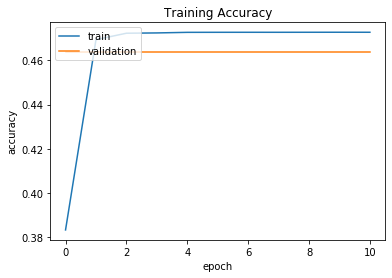

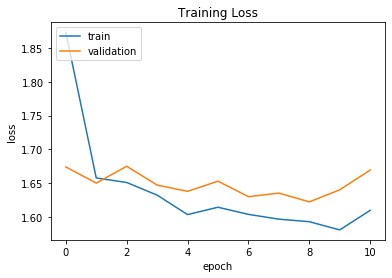

<Figure size 432x288 with 0 Axes>

In [7]:
#Graficos
'''
#Matriz de confusion
lab = [x for x in range(0,num_class)]
matrix = multilabel_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), labels = lab)
print(matrix)

import seaborn as sns

ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax); #annot=True to annotate cells
plt.savefig(fname = "/global/scratch/users/cpezov/AAPBO/models/v4/vgg-v4/results/confMat.png")
'''
#model.load_weights("/global/scratch/users/cpezov/AAPBO/models/v4/vgg-v4/models/model.h5") #cargalo de tu ruta
score = model.evaluate(x_test, y_test,verbose=1)
print("MODEL Metric names: ", model.metrics_names)
print("loss:", score[0])
print("accuracy:", score[1])
print("mse:", score[2])

print("HISTORY Keys: ", vgg16L_HISTORY.history.keys())
plt.figure(0)
plt.plot(vgg16L_HISTORY.history['acc'])
plt.plot(vgg16L_HISTORY.history['val_acc'])
plt.title("Training Accuracy") 
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(main_path+'models/v4/vgg-v4/results/acc_graph.png')

# summarize history for loss
plt.figure(1)
plt.plot(vgg16L_HISTORY.history['loss'])
plt.plot(vgg16L_HISTORY.history['val_loss'])
plt.title("Training Loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.savefig(main_path+'models/v4/vgg-v4/results/loss_graph.png')

# Prediction Time

In [4]:
#Load model

# load json and create model
json_file = open(main_path+"models/v4/vgg-v4/models/model.json", 'r')
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)

# load weights into new model
model.load_weights(main_path+"models/v4/vgg-v4/models/model.h5")
print("Loaded model from disk")

loss="categorical_crossentropy"
opt = Adam(lr = 0.0001,epsilon=1e-08) 

model.compile(loss=loss, optimizer=opt, metrics=['acc', 'mse'])      
model.summary() #ver resumen red

Loaded model from disk
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14713536  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              134221824 
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (Non

In [5]:
#Verify model has same metrics

y_pred_onehot = model.predict(x_test, verbose=1)
y_pred = np.argmax(y_pred_onehot, axis=2)

score = model.evaluate(x_test, y_test,verbose=1)
print("MODEL Metric names: ", model.metrics_names)
print("loss:", score[0])
print("accuracy:", score[1])
print("mse:", score[2])

34/34 [==============================] - 2s 51ms/step - loss: 1.6271 - acc: 0.4713 - mse: 0.1249
MODEL Metric names:  ['loss', 'acc', 'mse']
loss: 1.6270664930343628
accuracy: 0.4712904989719391
mse: 0.1248830184340477


In [6]:
#Calcular tiempos de predicción por cada par instancia-tiempo de test
#(Correr esto se demora 1 hora aprox)

now=datetime.datetime.now()
print(now)

l=int(len(y_pred))
t_preds=np.empty(l*500) #Una predicción da los resultados de todos los 500 timesteps

#prediccion
for i in range(len(x_test)):
    #crear np.array de solo esa instancia-timestep
    x_i = [x_test[i]]
    x_i = np.array(x_i)
    
    #hacer predicción y medir tiempo
    start=time.time()
    y_i = model.predict(x_i)
    tiempo=time.time()-start
    #Por cada instancia, guardar el mismo tiempo de predicción para los 500 timesteps (para obtener el resultado de 1 timestep, el modelo debe obtener la predicción para todos los timesteps, por lo que el tiempo que toma es el mismo para todos los timesteps)
    for j in range(500): 
        t_preds[500*i+j]=tiempo

2024-03-05 18:12:13.497918


In [7]:
#Guardar tiempos de prediccion

print(t_preds)
f = open(main_path+"models/results-v4/pred_times/t_pred_vgg-v4.txt", "w")
np.savetxt(f, t_preds, delimiter=" ", fmt="%s")
f.close()

[0.1656251  0.1656251  0.1656251  ... 0.07169271 0.07169271 0.07169271]


In [8]:
now=datetime.datetime.now()
print(now)

2024-03-05 18:13:32.454523
